In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causallearn.search.ScoreBased.GES import ges
from causallearn.graph.Endpoint import Endpoint
from collections import Counter
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from itertools import permutations
import pyEDM
import os
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from tqdm import tqdm
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

GES Method


=== Causal Edge Analysis ===
Analyzed 148 trajectories
Found 30 directed edge types
Found 30 undirected edge types


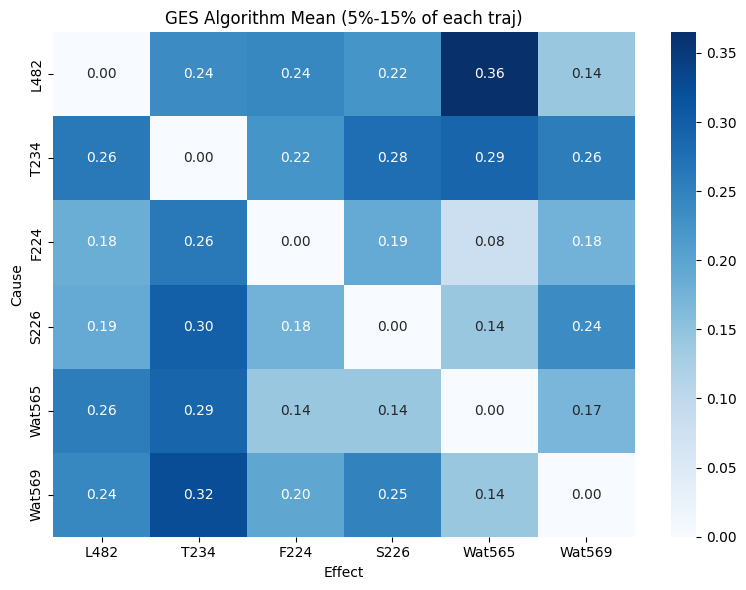

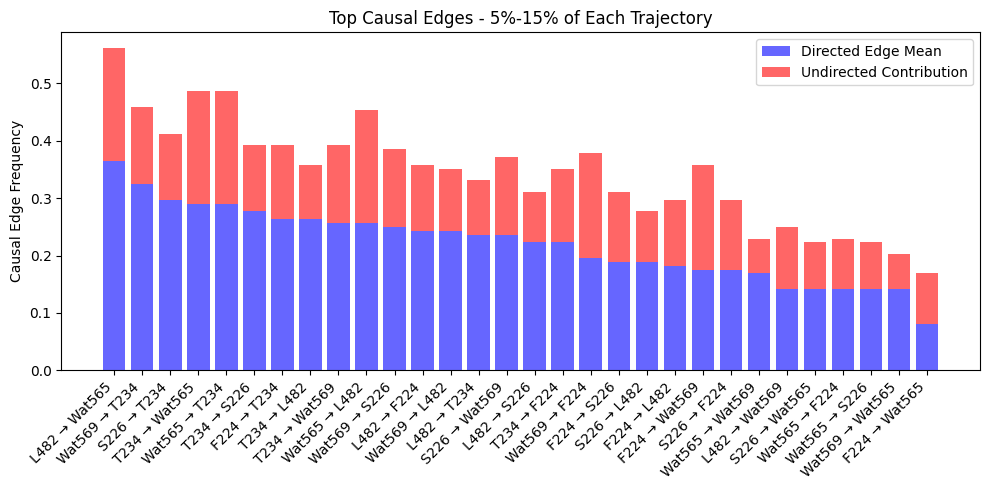


=== All Directed Edges ===
L482 → Wat565: 0.36 frequency
Wat569 → T234: 0.32 frequency
S226 → T234: 0.30 frequency
T234 → Wat565: 0.29 frequency
Wat565 → T234: 0.29 frequency
T234 → S226: 0.28 frequency
F224 → T234: 0.26 frequency
T234 → L482: 0.26 frequency
T234 → Wat569: 0.26 frequency
Wat565 → L482: 0.26 frequency
Wat569 → S226: 0.25 frequency
L482 → F224: 0.24 frequency
Wat569 → L482: 0.24 frequency
L482 → T234: 0.24 frequency
S226 → Wat569: 0.24 frequency
L482 → S226: 0.22 frequency
T234 → F224: 0.22 frequency
Wat569 → F224: 0.20 frequency
F224 → S226: 0.19 frequency
S226 → L482: 0.19 frequency
F224 → L482: 0.18 frequency
F224 → Wat569: 0.18 frequency
S226 → F224: 0.18 frequency
Wat565 → Wat569: 0.17 frequency
L482 → Wat569: 0.14 frequency
S226 → Wat565: 0.14 frequency
Wat565 → F224: 0.14 frequency
Wat565 → S226: 0.14 frequency
Wat569 → Wat565: 0.14 frequency
F224 → Wat565: 0.08 frequency

=== All Undirected Edges ===
L482 -- Wat565: 0.20 frequency
T234 -- Wat565: 0.20 frequency


In [ ]:
# Load data
file_path = "./dataset/hmr3_traj_important_features.npy"
with open(file_path, "rb") as f:
    traj = np.load(f)
    labels = np.load(f)

# Create output directory
output_dir = "causal_graphs_ges_comparison"
os.makedirs(output_dir, exist_ok=True)

# Residue names
residue_names = ["L482", "T234", "F224", "S226", "Wat565", "Wat569"]

def compute_causal_graph(segment_data):
    """Compute the causal graph for a trajectory segment using the GES method.

    Args:
        segment_data (np.ndarray): Input trajectory data segment with shape (T, 6),
            where T is the number of time steps.

    Returns:
        tuple[list[tuple[str, str]], list[tuple[str, str]]]: 
        - Directed edges as a list of (cause, effect) tuples.
        - Undirected edges as a list of (node1, node2) tuples (both directions included).
    """
    # Reshape trajectory data
    segment_data = segment_data.reshape(segment_data.shape[0], -1, 6)
    segment_data = segment_data.reshape(-1, 6)
    
    # Run GES algorithm
    cg_result = ges(segment_data)
    cg = cg_result["G"]  # Extract causal graph
    
    # Classify edges
    edges_directed = []
    edges_undirected = []
    for edge in cg.get_graph_edges():
        node1 = residue_names[int(edge.get_node1().get_name()[1:]) - 1]
        node2 = residue_names[int(edge.get_node2().get_name()[1:]) - 1]
        
        # Directed edges (A->B or B->A)
        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.TAIL:
            edges_directed.append((node1, node2))
        elif edge.get_endpoint1() == Endpoint.TAIL and edge.get_endpoint2() == Endpoint.ARROW:
            edges_directed.append((node2, node1))
        # Undirected edges (A-B)
        else:
            edges_undirected.append((node1, node2))
            edges_undirected.append((node2, node1))  # Add both directions
    
    return edges_directed, edges_undirected

def calculate_edge_frequencies(edge_sets):
    """Calculate average frequencies of directed and undirected edges.

    Args:
        edge_sets (list[tuple[list[tuple[str, str]], list[tuple[str, str]]]]): 
            List of edge sets for each trajectory. Each entry contains:
            - A list of directed edges.
            - A list of undirected edges.

    Returns:
        tuple[dict[tuple[str, str], float], dict[tuple[str, str], float]]:
        - Mean directed edge frequencies across all trajectories.
        - Mean undirected edge frequencies across all trajectories.
    """
    directed_counts = [Counter(edges[0]) for edges in edge_sets]
    undirected_counts = [Counter(edges[1]) for edges in edge_sets]
    
    # Get all unique edges
    all_directed_edges = sorted(set(edge for counts in directed_counts for edge in counts))
    all_undirected_edges = sorted(set(edge for counts in undirected_counts for edge in counts))
    
    # Calculate mean frequencies
    mean_directed = {edge: np.mean([counts.get(edge, 0) for counts in directed_counts]) 
                    for edge in all_directed_edges}
    mean_undirected = {edge: np.mean([counts.get(edge, 0) for counts in undirected_counts])
                     for edge in all_undirected_edges}
    
    return mean_directed, mean_undirected

def create_frequency_matrix(mean_values, node_names):
    """Create a frequency matrix for visualization.

    Args:
        mean_values (dict[tuple[str, str], float]): Mean edge frequencies.
        node_names (list[str]): List of node names.

    Returns:
        np.ndarray: A 2D frequency matrix of shape (num_nodes, num_nodes).
    """
    num_nodes = len(node_names)
    freq_matrix = np.zeros((num_nodes, num_nodes))
    
    for edge, mean in mean_values.items():
        i = node_names.index(edge[0])
        j = node_names.index(edge[1])
        freq_matrix[i, j] = mean
    
    return freq_matrix

def plot_heatmap(matrix, graph_name, variables_names, title_suffix=""):
    """Plot a heatmap of edge frequencies.

    Args:
        matrix (np.ndarray): Frequency matrix of shape (num_nodes, num_nodes).
        graph_name (str): Name of the algorithm (e.g., 'GES').
        variables_names (list[str]): List of variable or node names.
        title_suffix (str, optional): Additional suffix for plot title. Defaults to "".
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=variables_names, yticklabels=variables_names)
    plt.title(f"{graph_name} Algorithm {title_suffix}")
    plt.xlabel("Effect")
    plt.ylabel("Cause")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"heatmap_{title_suffix.replace(' ', '_')}.png"))
    plt.show()

def plot_edge_comparison(mean_directed, mean_undirected, title_suffix="All Edges"):
    """Plot comparison of directed and undirected edge frequencies.

    Args:
        mean_directed (dict[tuple[str, str], float]): Mean frequencies of directed edges.
        mean_undirected (dict[tuple[str, str], float]): Mean frequencies of undirected edges.
        title_suffix (str, optional): Title suffix for the plot. Defaults to "All Edges".
    """
    # Sort edges by frequency
    edges = sorted(mean_directed.keys(), key=lambda x: mean_directed[x], reverse=True)
    means = [mean_directed[edge] for edge in edges]
    undirected_means = [mean_undirected.get(edge, 0) for edge in edges]
    
    # Create plot
    x = np.arange(len(edges))
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Directed edges (blue)
    ax.bar(x, means, color='blue', alpha=0.6, label='Directed Edge Mean')
    
    # Undirected contribution (red, stacked)
    ax.bar(x, undirected_means, bottom=means, color='red', alpha=0.6, 
           label='Undirected Contribution')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f"{edge[0]} → {edge[1]}" for edge in edges], 
                      rotation=45, ha="right")
    ax.set_ylabel("Causal Edge Frequency")
    ax.set_title(f"Top Causal Edges - {title_suffix}")
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"edge_comparison_{title_suffix.replace(' ', '_')}.png"))
    plt.show()

# --------------------------- Main Analysis ---------------------------
# Process each trajectory by taking 5%-15% time segment
edge_sets = []
for i in range(traj.shape[0]):
    full_traj = traj[i]  # shape: (T, 6)
    time_len = full_traj.shape[0]
    start_t = int(0.05 * time_len)
    end_t = int(0.15 * time_len)
    segment = full_traj[start_t:end_t, :]  # Extract 5%-15% segment
    edge_sets.append(compute_causal_graph(segment))

# Calculate edge frequencies
mean_directed, mean_undirected = calculate_edge_frequencies(edge_sets)

# Generate frequency matrix
freq_matrix = create_frequency_matrix(mean_directed, residue_names)

# Print summary statistics
print("\n=== Causal Edge Analysis ===")
print(f"Analyzed {len(edge_sets)} trajectories")
print(f"Found {len(mean_directed)} directed edge types")
print(f"Found {len(mean_undirected)} undirected edge types")

# Plot results
plot_heatmap(freq_matrix, "GES", residue_names, "Mean (5%-15% of each traj)")
plot_edge_comparison(mean_directed, mean_undirected, "5%-15% of Each Trajectory")

# Print all edges
print("\n=== All Directed Edges ===")
for edge, freq in sorted(mean_directed.items(), key=lambda x: x[1], reverse=True):
    print(f"{edge[0]} → {edge[1]}: {freq:.2f} frequency")

print("\n=== All Undirected Edges ===")
for edge, freq in sorted(mean_undirected.items(), key=lambda x: x[1], reverse=True):
    print(f"{edge[0]} -- {edge[1]}: {freq:.2f} frequency")


Potential causal edges (x → y) with rho > 0.20:
L482 → Wat565: rho = 0.377
L482 → Wat569: rho = 0.352
T234 → Wat569: rho = 0.221
S226 → Wat565: rho = 0.320
S226 → Wat569: rho = 0.270
Wat565 → L482: rho = 0.412
Wat565 → T234: rho = 0.432
Wat565 → F224: rho = 0.295
Wat565 → S226: rho = 0.517
Wat565 → Wat569: rho = 0.812
Wat569 → L482: rho = 0.352
Wat569 → T234: rho = 0.343
Wat569 → S226: rho = 0.252
Wat569 → Wat565: rho = 0.643


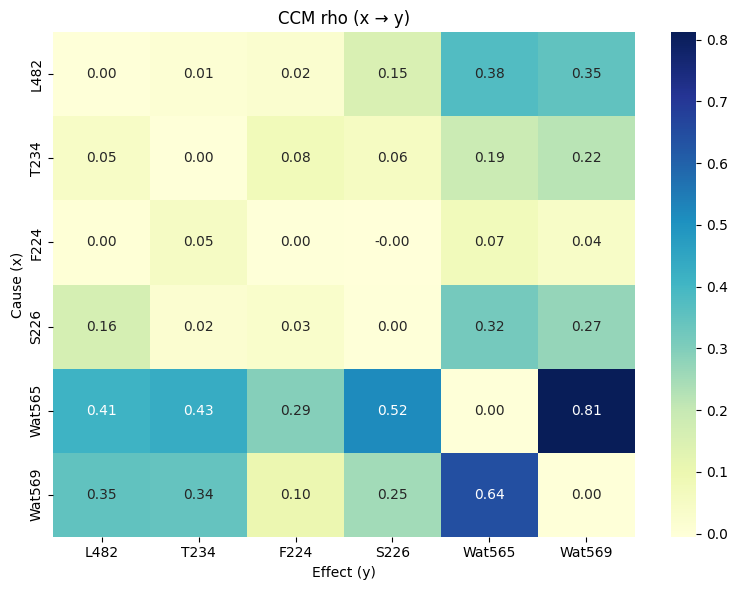

In [ ]:
# Load data
file_path = "./dataset/hmr3_traj_important_features.npy"
with open(file_path, "rb") as f:
    traj = np.load(f)  
    labels = np.load(f)

# Extract 5%–15% segment of each trajectory (frames 1250 to 3750)
traj = traj[:, 1250:3750, :]  # shape: (148, 2500, 6)

# Compute mean trajectory across all simulations → shape: (2500, 6)
mean_traj = np.mean(traj, axis=0)

# Define residue names and initialize result container
residue_names = ["L482", "T234", "F224", "S226", "Wat565", "Wat569"]
causal_results = []

# Iterate over all pairs of variables (excluding self-pairs)
for i, j in permutations(range(6), 2):
    x = mean_traj[:, i]
    y = mean_traj[:, j]

    # Create lagged dataframe for CCM input
    df = pd.DataFrame({
        "time": np.arange(1, len(x) + 1),
        "x": x,
        "x_t-1": np.roll(x, 1),
        "y": y,
        "y_t-1": np.roll(y, 1)
    }).iloc[1:].reset_index(drop=True)  # Drop first row due to lag

    # Run CCM from x → y using embedded vectors ["x", "x_t-1"]
    result = pyEDM.CCM(
        dataFrame=df,
        E=2,
        columns=["x", "x_t-1"],
        target="y",
        libSizes="500",      
        sample=10,            
        embedded=True,
        showPlot=False
    )

    # Extract final rho value (last row)
    rho_xy = result["x:y"].values[-1]
    causal_results.append((residue_names[i], residue_names[j], rho_xy))

# Filter edges based on threshold
threshold = 0.2
filtered_edges = [edge for edge in causal_results if edge[2] > threshold]

# Print causal edges
print("Potential causal edges (x → y) with rho > {:.2f}:".format(threshold))
for source, target, rho in filtered_edges:
    print(f"{source} → {target}: rho = {rho:.3f}")

# Optional – create and show heatmap of all rho values
matrix = np.zeros((6, 6))
for i, j, rho in causal_results:
    idx_i = residue_names.index(i)
    idx_j = residue_names.index(j)
    matrix[idx_i, idx_j] = rho

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, xticklabels=residue_names, yticklabels=residue_names,
            cmap="YlGnBu", fmt=".2f")
plt.title("CCM rho (x → y)")
plt.xlabel("Effect (y)")
plt.ylabel("Cause (x)")
plt.tight_layout()
plt.show()

PC Method

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Depth=3, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 1533.38it/s]


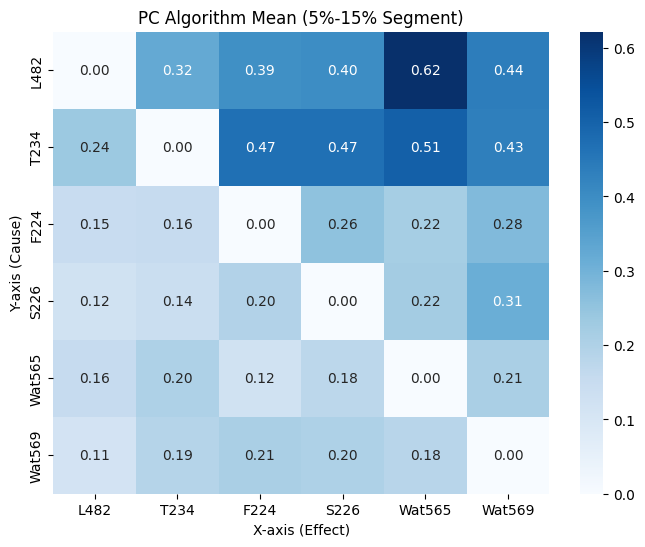


Mean Directed Edge Frequencies:
L482 → Wat565: 0.62
T234 → Wat565: 0.51
T234 → F224: 0.47
T234 → S226: 0.47
L482 → Wat569: 0.44
T234 → Wat569: 0.43
L482 → S226: 0.40
L482 → F224: 0.39
L482 → T234: 0.32
S226 → Wat569: 0.31
F224 → Wat569: 0.28
F224 → S226: 0.26
T234 → L482: 0.24
S226 → Wat565: 0.22
F224 → Wat565: 0.22
Wat565 → Wat569: 0.21
Wat569 → F224: 0.21
Wat565 → T234: 0.20
Wat569 → S226: 0.20
S226 → F224: 0.20
Wat569 → T234: 0.19
Wat569 → Wat565: 0.18
Wat565 → S226: 0.18
F224 → T234: 0.16
Wat565 → L482: 0.16
F224 → L482: 0.15
S226 → T234: 0.14
S226 → L482: 0.12
Wat565 → F224: 0.12
Wat569 → L482: 0.11

Mean Undirected Edge Frequencies:
S226 — Wat569: 0.16
Wat569 — S226: 0.16
F224 — Wat569: 0.12
Wat569 — F224: 0.12
F224 — S226: 0.11
S226 — F224: 0.11
T234 — Wat569: 0.11
Wat569 — T234: 0.11
T234 — Wat565: 0.10
Wat565 — T234: 0.10
S226 — T234: 0.09
T234 — S226: 0.09
F224 — Wat565: 0.09
Wat565 — F224: 0.09
L482 — Wat565: 0.08
Wat565 — L482: 0.08
L482 — T234: 0.07
T234 — L482: 0.07
S226

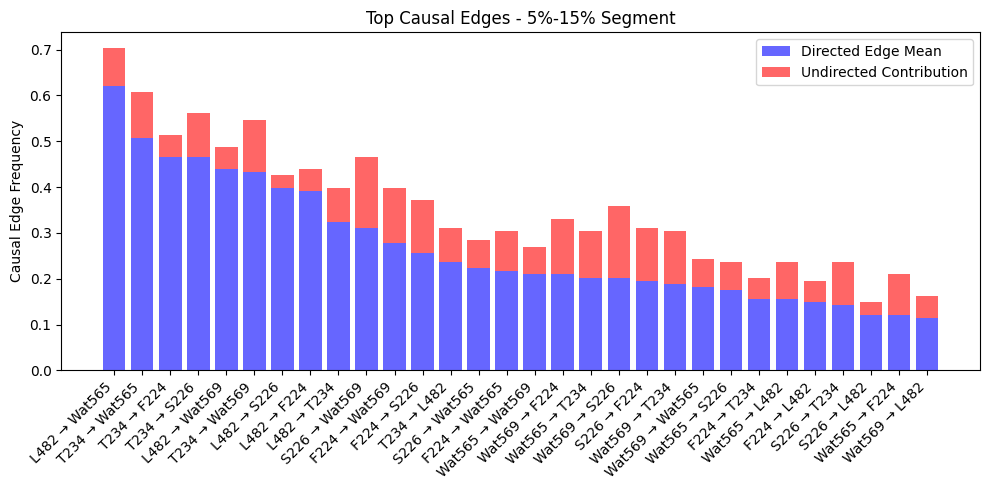

In [ ]:
# Load data
file_path = "./dataset/hmr3_traj_important_features.npy"
with open(file_path, "rb") as f:
    traj = np.load(f)     
    labels = np.load(f)

# Create directory to store causal graphs
output_dir = "causal_graphs_pc_comparison"
os.makedirs(output_dir, exist_ok=True)

# Define residue names
residue_names = ["L482", "T234", "F224", "S226", "Wat565", "Wat569"]

# Use only 5%-15% segment of each trajectory
start_frame = int(25000 * 0.05)   # 1250
end_frame = int(25000 * 0.15)     # 3750

def compute_causal_graph(segment_data):
    """Compute the causal graph using the PC algorithm on trajectory data.

    Args:
        segment_data (np.ndarray): Segment of trajectory data with shape (frames, variables).

    Returns:
        tuple[list[tuple[str, str]], list[tuple[str, str]]]:
            - List of directed edges (cause → effect).
            - List of undirected edges (bidirectional).
    """
    # Reshape and flatten segment
    segment_data = segment_data.reshape(segment_data.shape[0], -1, 6)
    segment_data = segment_data.reshape(-1, 6)
    
    # Run PC algorithm
    cg = pc(segment_data, alpha=0.05, indep_test=fisherz)
    
    # Extract edges
    edges_directed = []
    edges_undirected = []
    for edge in cg.G.get_graph_edges():
        node1 = residue_names[int(edge.get_node1().get_name()[1:]) - 1]
        node2 = residue_names[int(edge.get_node2().get_name()[1:]) - 1]
        
        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.TAIL:
            edges_directed.append((node1, node2))
        elif edge.get_endpoint1() == Endpoint.TAIL and edge.get_endpoint2() == Endpoint.ARROW:
            edges_directed.append((node2, node1))
        else:
            edges_undirected.append((node1, node2))
            edges_undirected.append((node2, node1))  # Count both directions for undirected edge
    
    return edges_directed, edges_undirected

def calculate_edge_frequencies(edge_sets):
    """Calculate average edge frequencies across multiple trajectories.

    Args:
        edge_sets (list[tuple[list[tuple[str, str]], list[tuple[str, str]]]]):
            List of directed and undirected edge sets for each trajectory.

    Returns:
        tuple[dict, dict]:
            - Dictionary of mean frequencies for directed edges.
            - Dictionary of mean frequencies for undirected edges.
    """
    num_traj = len(edge_sets)
    directed_counts = [Counter(edges[0]) for edges in edge_sets]
    undirected_counts = [Counter(edges[1]) for edges in edge_sets]
    
    all_directed_edges = sorted(set(edge for counts in directed_counts for edge in counts))
    all_undirected_edges = sorted(set(edge for counts in undirected_counts for edge in counts))
    
    mean_directed = {edge: np.mean([counts.get(edge, 0) for counts in directed_counts]) for edge in all_directed_edges}
    mean_undirected = {edge: np.mean([counts.get(edge, 0) for counts in undirected_counts]) for edge in all_undirected_edges}
    
    return mean_directed, mean_undirected

def create_frequency_matrix(mean_values, node_names):
    """Create a frequency matrix from mean edge frequencies.

    Args:
        mean_values (dict): Dictionary mapping edges to mean frequencies.
        node_names (list[str]): List of variable names (nodes).

    Returns:
        np.ndarray: Square matrix of mean edge frequencies.
    """
    num_nodes = len(node_names)
    freq_matrix = np.zeros((num_nodes, num_nodes))
    
    for edge, mean in mean_values.items():
        i = node_names.index(edge[0])
        j = node_names.index(edge[1])
        freq_matrix[i, j] = mean
    
    return freq_matrix

def plot_heatmap(matrix, graph_name, variables_names, title_suffix=""):
    """Plot a heatmap of edge frequencies.

    Args:
        matrix (np.ndarray): Frequency matrix.
        graph_name (str): Name of the algorithm (e.g., "PC").
        variables_names (list[str]): List of variable names.
        title_suffix (str, optional): Extra title information. Defaults to "".
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=variables_names, yticklabels=variables_names)
    plt.title(f"{graph_name} Algorithm {title_suffix}")
    plt.xlabel("X-axis (Effect)")
    plt.ylabel("Y-axis (Cause)")
    plt.show()

def plot_edge_comparison(mean_directed, mean_undirected, title_suffix="All Edges"):
    """Plot bar chart comparing directed and undirected edge frequencies.

    Args:
        mean_directed (dict): Mean directed edge frequencies.
        mean_undirected (dict): Mean undirected edge frequencies.
        title_suffix (str, optional): Extra title information. Defaults to "All Edges".
    """
    edges = sorted(mean_directed.keys(), key=lambda x: mean_directed[x], reverse=True)
    means = [mean_directed[edge] for edge in edges]
    undirected_means = [mean_undirected.get(edge, 0) for edge in edges]
    
    x = np.arange(len(edges))
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(x, means, color='blue', alpha=0.6, label='Directed Edge Mean')
    ax.bar(x, undirected_means, bottom=means, color='red', alpha=0.6, label='Undirected Contribution')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f"{edge[0]} → {edge[1]}" for edge in edges], rotation=45, ha="right")
    ax.set_ylabel("Causal Edge Frequency")
    ax.set_title(f"Top Causal Edges - {title_suffix}")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Compute edge sets for all trajectories using only 5%-15% segment
edge_sets = []
for i in range(traj.shape[0]):
    segment = traj[i, start_frame:end_frame, :]  # shape: (2500, 6)
    try:
        edges = compute_causal_graph(segment)
        edge_sets.append(edges)
    except Exception as e:
        print(f"Trajectory {i} failed: {e}")

# Compute average edge frequencies
mean_directed, mean_undirected = calculate_edge_frequencies(edge_sets)

# Create directed edge frequency matrix
freq_matrix = create_frequency_matrix(mean_directed, residue_names)

# Plot frequency heatmap
plot_heatmap(freq_matrix, "PC", residue_names, "Mean (5%-15% Segment)")

# Print mean directed edges and their frequencies
print("\nMean Directed Edge Frequencies:")
for edge, freq in sorted(mean_directed.items(), key=lambda x: -x[1]):
    print(f"{edge[0]} → {edge[1]}: {freq:.2f}")

# Print mean undirected edges and their frequencies
print("\nMean Undirected Edge Frequencies:")
for edge, freq in sorted(mean_undirected.items(), key=lambda x: -x[1]):
    print(f"{edge[0]} — {edge[1]}: {freq:.2f}")

# Plot edge frequency comparison
plot_edge_comparison(mean_directed, mean_undirected, "5%-15% Segment")


VARLINGAM


Analyzing dataset: HMR3 GPCR Trajectories (5-15% sampled) (Samples: 376085)


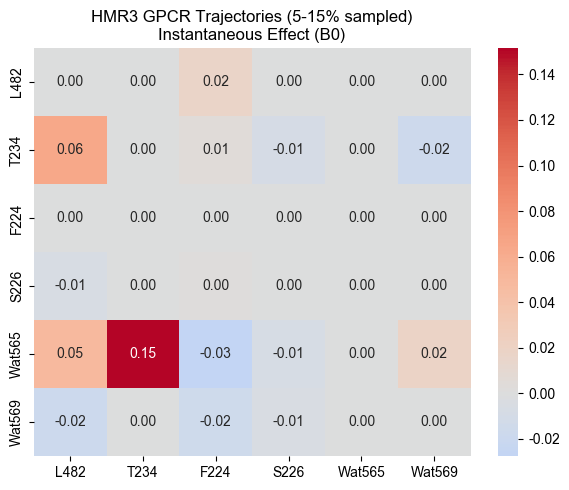

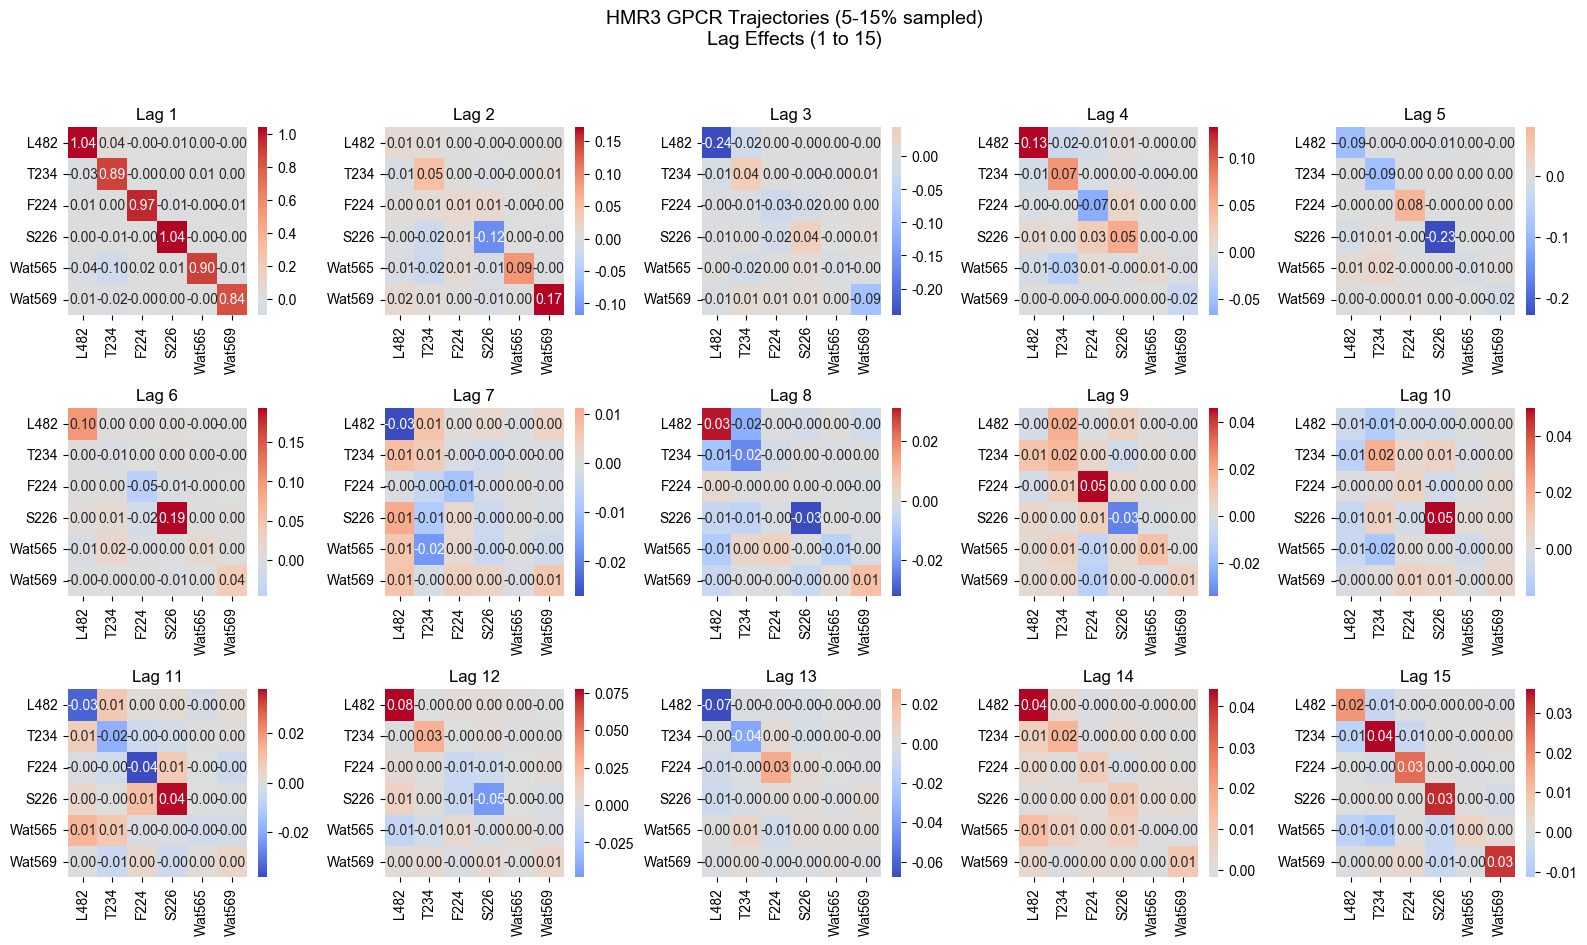


=== Significant Instantaneous Effects (|B0| > 0.05) ===
L482 → T234: positive effect (magnitude: 0.064)
T234 → Wat565: positive effect (magnitude: 0.152)

=== Significant Lag Effects (|coefficient| > 0.05) ===
L482(t-1) → L482(t): positive effect (magnitude: 1.037)
T234(t-1) → T234(t): positive effect (magnitude: 0.887)
F224(t-1) → F224(t): positive effect (magnitude: 0.975)
S226(t-1) → S226(t): positive effect (magnitude: 1.042)
T234(t-1) → Wat565(t): negative effect (magnitude: 0.100)
Wat565(t-1) → Wat565(t): positive effect (magnitude: 0.903)
Wat569(t-1) → Wat569(t): positive effect (magnitude: 0.839)
S226(t-2) → S226(t): negative effect (magnitude: 0.118)
Wat565(t-2) → Wat565(t): positive effect (magnitude: 0.090)
Wat569(t-2) → Wat569(t): positive effect (magnitude: 0.172)
L482(t-3) → L482(t): negative effect (magnitude: 0.240)
Wat569(t-3) → Wat569(t): negative effect (magnitude: 0.090)
L482(t-4) → L482(t): positive effect (magnitude: 0.132)
T234(t-4) → T234(t): positive effect (m

In [ ]:
# Set up font
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


class RobustLiNGAM:
    """Simplified implementation of the LiNGAM algorithm."""

    def __init__(self, max_iter=100):
        """
        Initialize the RobustLiNGAM model.

        Args:
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.
        """
        self.adjacency_matrix_ = None
        self.max_iter = max_iter

    def fit(self, X):
        """
        Fit the LiNGAM model to the given data.

        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            RobustLiNGAM: Fitted model with estimated adjacency matrix.
        """
        n_samples, n_features = X.shape
        W = np.zeros((n_features, n_features))
        remaining_vars = list(range(n_features))

        for _ in range(min(self.max_iter, n_features)):
            if len(remaining_vars) == 0:
                break

            X_centered = X - np.nanmean(X, axis=0)
            U = np.dot(X_centered, (np.eye(n_features) - W)) + 1e-10 * np.random.randn(*X_centered.shape)

            kurtosis = np.abs(np.nanmean(U**4, axis=0) - 3 * np.nanmean(U**2, axis=0) ** 2)
            m = remaining_vars[np.nanargmax(kurtosis[remaining_vars])]

            predictors = [v for v in remaining_vars if v != m]
            if not predictors:
                break

            try:
                coef = np.linalg.lstsq(X[:, predictors], X[:, m], rcond=None)[0]
            except Exception:
                coef = np.zeros(len(predictors))

            for i, var in enumerate(predictors):
                W[m, var] = coef[i]

            remaining_vars.remove(m)

        self.adjacency_matrix_ = W
        return self


def load_hmr3_data(file_path):
    """
    Load HMR3 trajectory data and extract 5–15% random segments.

    Args:
        file_path (str): Path to the `.npy` trajectory file.

    Returns:
        tuple:
            - X (numpy.ndarray): Combined sampled segments of shape (samples, variables).
            - residues (list): Names of the six variables in the dataset.
    """
    with open(file_path, "rb") as f:
        traj = np.load(f)  # shape: (148, 25000, 6)
        labels = np.load(f)

    sampled_trajs = []
    for i in range(traj.shape[0]):
        traj_length = traj.shape[1]
        min_length = int(0.05 * traj_length)
        max_length = int(0.15 * traj_length)
        sample_length = np.random.randint(min_length, max_length)
        start_idx = np.random.randint(0, traj_length - sample_length)
        sampled_segment = traj[i, start_idx:start_idx + sample_length, :]
        sampled_trajs.append(sampled_segment)

    X = np.vstack(sampled_trajs)
    residues = ['L482', 'T234', 'F224', 'S226', 'Wat565', 'Wat569']
    return X, residues


def analyze_all_lags(X, residues, dataset_name, max_lags=15):
    """
    Analyze lagged causal effects using VAR and LiNGAM.

    Args:
        X (numpy.ndarray): Input time series data of shape (n_samples, n_variables).
        residues (list): List of variable names.
        dataset_name (str): Name of the dataset for display.
        max_lags (int, optional): Maximum number of lags to include in VAR. Defaults to 15.

    Returns:
        tuple:
            - B0 (numpy.ndarray): Instantaneous effect matrix estimated by LiNGAM.
            - lag_effects (dict): Dictionary of lagged effect matrices.
            - max_lags (int): Number of lags used in the VAR model.
    """
    n_samples, n_vars = X.shape
    print(f"\nAnalyzing dataset: {dataset_name} (Samples: {n_samples})")
    X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)

    try:
        model_var = sm.tsa.VAR(X)
        results_var = model_var.fit(maxlags=max_lags, ic=None)
        all_coefs = results_var.coefs
        residuals = results_var.resid
    except Exception as e:
        print(f"VAR model fitting failed: {str(e)}")
        return None, None, None

    try:
        model_lingam = RobustLiNGAM()
        model_lingam.fit(residuals)
        B0 = model_lingam.adjacency_matrix_
    except Exception as e:
        print(f"LiNGAM fitting failed: {str(e)}")
        return None, None, None

    lag_effects = {
        f"lag_{k+1}": (np.eye(n_vars) - B0) @ all_coefs[k]
        for k in range(min(max_lags, len(all_coefs)))
    }
    return B0, lag_effects, max_lags


def plot_all_effects(B0, lag_effects, residues, title):
    """
    Plot instantaneous effects and lagged effects as heatmaps.

    Args:
        B0 (numpy.ndarray): Instantaneous effect matrix.
        lag_effects (dict): Dictionary of lagged effect matrices.
        residues (list): List of variable names.
        title (str): Title for the plots.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(B0, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                xticklabels=residues, yticklabels=residues)
    plt.title(f"{title}\nInstantaneous Effect (B0)")
    plt.tight_layout()
    plt.show()

    lags = list(lag_effects.keys())
    total = len(lags)
    cols = 5
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))
    axes = axes.flatten()

    for idx, lag in enumerate(lags):
        sns.heatmap(lag_effects[lag], annot=True, fmt=".2f", cmap="coolwarm", center=0,
                    xticklabels=residues, yticklabels=residues, ax=axes[idx])
        axes[idx].set_title(f"{lag.replace('_', ' ').title()}")

    for i in range(len(lags), len(axes)):
        axes[i].axis("off")

    plt.suptitle(f"{title}\nLag Effects (1 to {total})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def print_significant_effects(B0, lag_effects, residues, threshold=0.05):
    """
    Print significant instantaneous and lagged effects.

    Args:
        B0 (numpy.ndarray): Instantaneous effect matrix.
        lag_effects (dict): Dictionary of lagged effect matrices.
        residues (list): List of variable names.
        threshold (float, optional): Significance threshold for effect magnitude. Defaults to 0.05.
    """
    print(f"\n=== Significant Instantaneous Effects (|B0| > {threshold}) ===")
    for i, target in enumerate(residues):
        for j, source in enumerate(residues):
            if i != j and abs(B0[i, j]) > threshold:
                direction = "positive" if B0[i, j] > 0 else "negative"
                print(f"{source} → {target}: {direction} effect (magnitude: {abs(B0[i, j]):.3f})")

    print(f"\n=== Significant Lag Effects (|coefficient| > {threshold}) ===")
    for lag, mat in lag_effects.items():
        lag_num = int(lag.split('_')[1])
        for i, target in enumerate(residues):
            for j, source in enumerate(residues):
                if abs(mat[i, j]) > threshold:
                    direction = "positive" if mat[i, j] > 0 else "negative"
                    print(f"{source}(t-{lag_num}) → {target}(t): {direction} effect (magnitude: {abs(mat[i, j]):.3f})")


if __name__ == "__main__":
    file_path = "./dataset/hmr3_traj_important_features.npy"
    X, residues = load_hmr3_data(file_path)

    max_lags = 15
    dataset_name = "HMR3 GPCR Trajectories (5-15% sampled)"

    B0, lag_effects, lags_used = analyze_all_lags(X, residues, dataset_name, max_lags)

    if B0 is not None and lag_effects is not None:
        plot_all_effects(B0, lag_effects, residues, dataset_name)
        print_significant_effects(B0, lag_effects, residues, threshold=0.05)

        results = {
            'B0': pd.DataFrame(B0, index=residues, columns=residues),
            'lag_effects': {k: pd.DataFrame(v, index=residues, columns=residues)
                            for k, v in lag_effects.items()}
        }


PCMCI

Running PCMCI on all trajectories...


100%|██████████| 148/148 [25:30<00:00, 10.34s/it]


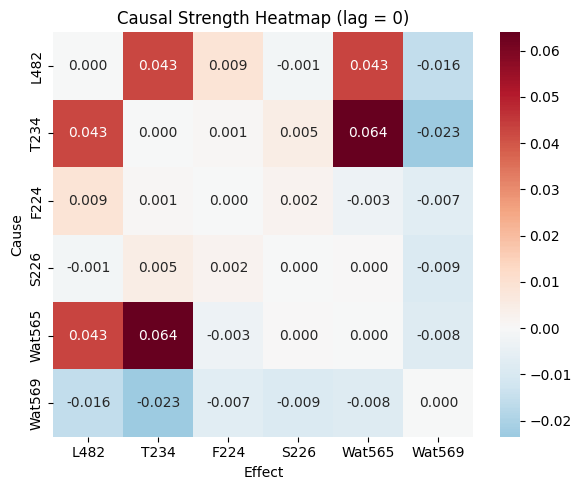

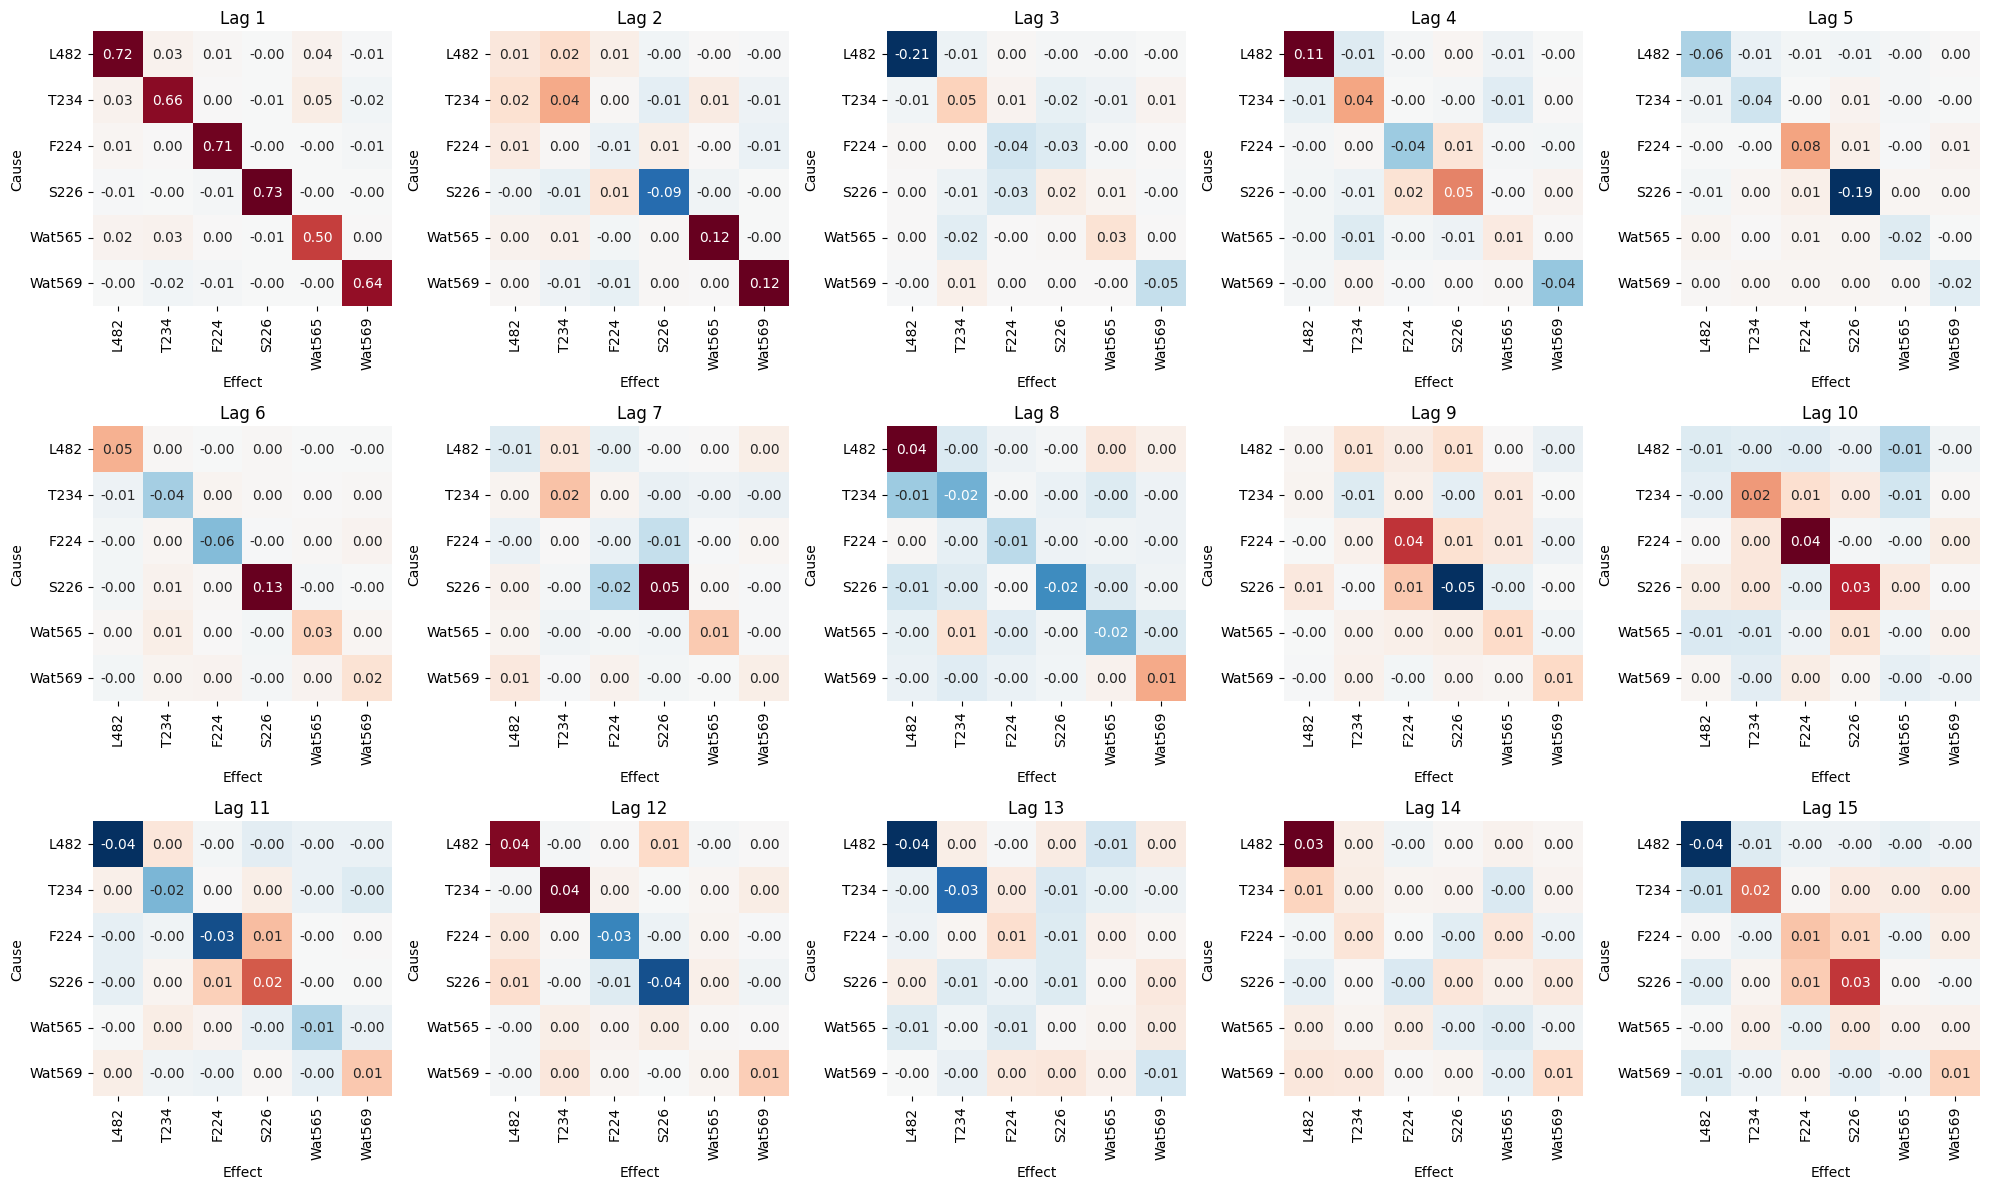


Significant causal edges (|strength| > 0.01):
L482 → T234 (lag=0): 0.043
L482 → Wat565 (lag=0): 0.043
L482 → Wat569 (lag=0): -0.016
T234 → L482 (lag=0): 0.043
T234 → Wat565 (lag=0): 0.064
T234 → Wat569 (lag=0): -0.023
Wat565 → L482 (lag=0): 0.043
Wat565 → T234 (lag=0): 0.064
Wat569 → L482 (lag=0): -0.016
Wat569 → T234 (lag=0): -0.023
L482 → L482 (lag=1): 0.716
L482 → T234 (lag=1): 0.030
L482 → Wat565 (lag=1): 0.035
T234 → L482 (lag=1): 0.034
T234 → T234 (lag=1): 0.657
T234 → Wat565 (lag=1): 0.054
T234 → Wat569 (lag=1): -0.023
F224 → L482 (lag=1): 0.013
F224 → F224 (lag=1): 0.708
F224 → Wat569 (lag=1): -0.012
S226 → S226 (lag=1): 0.730
Wat565 → L482 (lag=1): 0.024
Wat565 → T234 (lag=1): 0.034
Wat565 → Wat565 (lag=1): 0.502
Wat569 → T234 (lag=1): -0.023
Wat569 → F224 (lag=1): -0.012
Wat569 → Wat569 (lag=1): 0.642
L482 → L482 (lag=2): 0.013
L482 → T234 (lag=2): 0.020
T234 → L482 (lag=2): 0.018
T234 → T234 (lag=2): 0.044
T234 → S226 (lag=2): -0.011
F224 → L482 (lag=2): 0.011
S226 → F224 (

In [ ]:
# ------------------- Load Data -------------------
file_path = "./dataset/hmr3_traj_important_features.npy"
with open(file_path, "rb") as f:
    traj = np.load(f)  # shape: (148, 25000, 6)
    labels = np.load(f)

# Use only the 5%–15% segment of each trajectory
start_frame = int(25000 * 0.05)
end_frame = int(25000 * 0.15)

residue_names = ["L482", "T234", "F224", "S226", "Wat565", "Wat569"]

tau_max = 15

def run_pcmci_on_segment(segment):
    """Run PCMCI algorithm on a trajectory segment.

    Args:
        segment (np.ndarray): A 2D array of shape (time_steps, variables),
            representing the time series data for one trajectory segment.

    Returns:
        np.ndarray: The value matrix of causal strengths with shape
            (num_vars, num_vars, tau_max+1), where each entry represents
            the causal strength from one variable to another at a given lag.
    """
    # segment shape: (time_steps, variables)
    dataframe = pp.DataFrame(segment)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance='analytic'), verbosity=0)
    results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)  # No PC filtering, test all pairs
    val_matrix = results['val_matrix']  # shape: (num_vars, num_vars, tau_max+1)
    return val_matrix

val_matrices = []
print("Running PCMCI on all trajectories...")

for i in tqdm(range(traj.shape[0])):
    segment = traj[i, start_frame:end_frame, :]  # shape: (2500, 6)
    try:
        val_matrix = run_pcmci_on_segment(segment)
        val_matrices.append(val_matrix)
    except Exception as e:
        print(f"Trajectory {i} failed with error: {e}")

# Compute average causal strength matrix
avg_val_matrix = np.mean(val_matrices, axis=0)  # shape: (6, 6, 16)

# ------------------- Plot heatmap for lag = 0 -------------------
plt.figure(figsize=(6, 5))
sns.heatmap(avg_val_matrix[:, :, 0], annot=True, fmt=".3f",
            cmap="RdBu_r", center=0,
            xticklabels=residue_names, yticklabels=residue_names)
plt.title("Causal Strength Heatmap (lag = 0)")
plt.xlabel("Effect")
plt.ylabel("Cause")
plt.tight_layout()
plt.show()

# ------------------- Plot heatmaps for lag = 1 to lag = 15 in 3 rows × 5 columns -------------------
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
for lag in range(1, tau_max + 1):
    row = (lag - 1) // 5
    col = (lag - 1) % 5
    ax = axes[row, col]
    sns.heatmap(avg_val_matrix[:, :, lag], annot=True, fmt=".2f",
                cmap="RdBu_r", center=0,
                xticklabels=residue_names, yticklabels=residue_names,
                ax=ax, cbar=False)
    ax.set_title(f"Lag {lag}")
    ax.set_xlabel("Effect")
    ax.set_ylabel("Cause")

plt.tight_layout()
plt.show()

# ------------------- Print significant causal edges -------------------
print("\nSignificant causal edges (|strength| > 0.01):")
threshold = 0.01
num_vars = avg_val_matrix.shape[0]

for lag in range(tau_max + 1):
    for i in range(num_vars):
        for j in range(num_vars):
            strength = avg_val_matrix[i, j, lag]
            if abs(strength) > threshold:
                cause = residue_names[i]
                effect = residue_names[j]
                print(f"{cause} → {effect} (lag={lag}): {strength:.3f}")


Transfer Entropy

In [ ]:
# ==== Load HMR3 trajectory dataset ====
file_path = "./dataset/hmr3_traj_important_features.npy"
with open(file_path, "rb") as f:
    traj = np.load(f)     # shape: (148, 25000, 6)
    _ = np.load(f)        # labels (not used)

# ==== Randomly select 20 trajectories ====
np.random.seed(42)  # For reproducibility
indices = np.random.choice(traj.shape[0], size=20, replace=False)
traj_subset = traj[indices]  # shape: (20, 25000, 6)

# ==== Extract the 1%–2% segment ====
start_frame = int(traj.shape[1] * 0.01)
end_frame = int(traj.shape[1] * 0.02)
segment = traj_subset[:, start_frame:end_frame, :]  # shape: (20, 250, 6)

# ==== Reshape to (variables, time points) ====
reshaped_data = segment.transpose(2, 0, 1).reshape(6, -1)  # shape: (6, 5000)
data = Data(reshaped_data, dim_order='ps')

print(f"Selected 20 trajectories and extracted frames {start_frame}–{end_frame}")
print(f"Reshaped data to: {reshaped_data.shape} (variables × time points)")

# ==== Analysis configuration ====
settings = {
    'cmi_estimator': 'JidtKraskovCMI', 
    'max_lag_sources': 15,
    'min_lag_sources': 1,
    'verbosity': 1,
    'n_perm_max_stat': 100,
    'n_perm_omnibus': 100,
    'tau_min': 1,
    'tau_max': 1,
}

# ==== Run transfer entropy analysis ====
network_analysis = MultivariateTE()
results = network_analysis.analyse_network(settings=settings, data=data)


Adding data with properties: 6 processes, 5000 samples, 1 replications
overwriting existing data
Selected 20 trajectories and extracted frames 250–500
Reshaped data to: (6, 5000) (variables × time points)

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5]

Target: 0 - testing sources [1, 2, 3, 4, 5]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 100
testing candidate: (0, 3) maximum statistic, n_perm: 100
testing candidate: (0, 8) maximum statistic, n_perm: 100
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 1